In [5]:
import networkx as nx
import pulp
from pandas import DataFrame

# Data

In [6]:
candidates = ["NY-Eng", "NY-Man", "NY-Des", "BO-Eng"]
candidate_numbers = [5, 2, 2, 3]
offices = ["A", "B", "C", "D", "E"]
cities = ["NY", "BO"]
office_cities = [("A", "NY"), ("B", "NY"), ("C", "NY"),
                 ("D", "BO"), ("E", "BO")]
capacities = [3, 2, 6, 2, 5]
positions = ["Man", "Eng", "Des"]
teams = ["a", "b", "g"]
position_teams = [("Man", "a"), ("Eng", "a"), ("Eng", "b"),
                  ("Eng", "g"), ("Des", "a"), ("Des", "g")]
requirements = [2, 4, 3, 1, 1, 1]

candidate_numbers = dict(zip(candidates, candidate_numbers))
position_team_requirements = dict(zip(position_teams, requirements))
office_capacities = dict(zip(office_cities, capacities))

In [7]:
position_team_requirements

{('Man', 'a'): 2,
 ('Eng', 'a'): 4,
 ('Eng', 'b'): 3,
 ('Eng', 'g'): 1,
 ('Des', 'a'): 1,
 ('Des', 'g'): 1}

# Network

In [8]:
G=nx.DiGraph()

G.add_nodes_from(["s"],layer=0)
G.add_nodes_from(candidates,layer=1)
G.add_nodes_from(positions,layer=2)
G.add_nodes_from(teams,layer=3)
G.add_nodes_from(offices,layer=4)
G.add_nodes_from(cities,layer=5)
G.add_nodes_from(["t"],layer=6)

for v in candidates:
    G.add_edge("s",v)
    
G.add_edge("NY-Eng","Eng")
G.add_edge("NY-Man","Man")
G.add_edge("NY-Des","Des")
G.add_edge("BO-Eng","Eng")

G.add_edge("Man","a")
G.add_edge("Eng","a")
G.add_edge("Eng","b")
G.add_edge("Eng","g")
G.add_edge("Des","a")
G.add_edge("Des","g")

G.add_edge("a","A")
G.add_edge("a","B")
G.add_edge("a","C")
G.add_edge("a","D")
G.add_edge("a","E")
G.add_edge("b","A")
G.add_edge("b","B")
G.add_edge("b","C")
G.add_edge("b","D")
G.add_edge("b","E")
G.add_edge("g","A")
G.add_edge("g","B")
G.add_edge("g","C")
G.add_edge("g","D")
G.add_edge("g","E")

G.add_edge("A","NY")
G.add_edge("B","NY")
G.add_edge("C","NY")
G.add_edge("D","BO")
G.add_edge("E","BO")

for u in cities:
    G.add_edge(u,"t")

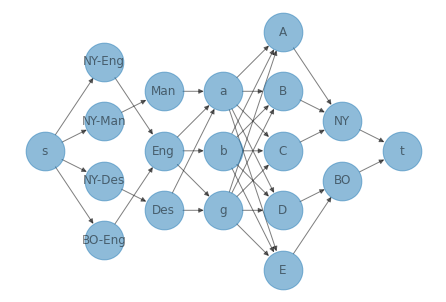

In [9]:
nx.draw(G, pos=nx.multipartite_layout(G, subset_key="layer"),
        with_labels=True, node_size=1500, alpha=0.5)

# MIP

In [10]:
prob = pulp.LpProblem("MultiCommodityFlow", pulp.LpMinimize)
x = {}
for (i, j) in G.edges():
    x[(i, j)] = pulp.LpVariable.dicts(
        "x_(%s,%s)" % (i, j),
        ([c for c in candidates]),
        cat=pulp.LpInteger,
        lowBound=0
    )
y = pulp.LpVariable.dicts(
    "y",
    ((i, j) for (i, j) in G.edges() if G.nodes[i]["layer"] == 3),
    cat=pulp.LpBinary,
)
prob += pulp.lpSum(y)

# flow conservation
for c in candidates:
    for v in G.nodes():
        if v not in ["s", "t"]:
            prob += pulp.lpSum(x[(u, v)][c] for u in G.predecessors(v)
                               ) == pulp.lpSum(x[(v, u)][c] for u in G.successors(v))

# office capacities
for (i, j) in office_capacities:
    prob += pulp.lpSum(x[(i, j)][c]
                       for c in x[(i, j)]) <= office_capacities[(i, j)]

# teams requirements
for (p, t) in position_team_requirements:
    prob += pulp.lpSum(x[(p, t)][c]
                       for c in x[(p, t)]) == position_team_requirements[(p, t)]

# candidates input
for c in candidate_numbers:
    prob += x[("s", c)][c] == candidate_numbers[c]

# link x and y variables
for (i, j) in y:
    for c in candidates:
        prob += x[(i, j)][c] <= 10*y[(i, j)]

In [11]:
#prob

In [12]:
prob.solve()

1

# Solution

In [13]:
for c in candidates:
    print(c)
    print("=======")
    for (i,j) in G.edges():
        val = pulp.value(x[(i, j)][c])
        if val > 0.8:
            if i!="s" and j!="t" and i!=c: # and j!=c:
                print(i, j, val) 
    print("")

NY-Eng
Eng a 1.0
Eng b 3.0
Eng g 1.0
a C 1.0
b E 3.0
g B 1.0
B NY 1.0
C NY 1.0
E BO 3.0

NY-Man
Man a 2.0
a C 2.0
C NY 2.0

NY-Des
Des a 1.0
Des g 1.0
a C 1.0
g B 1.0
B NY 1.0
C NY 1.0

BO-Eng
Eng a 3.0
a C 1.0
a E 2.0
C NY 1.0
E BO 2.0



In [14]:
for i in G.nodes():
    if G.nodes[i]["layer"]==3:
        print()
        print("Team ",i)
        print("======")
    for j in G.nodes():
        if (i,j) in y:
            val = pulp.value(y[(i,j)])
            if val > 0.9:
                print("office",j,"->",sum(pulp.value(x[(i,j)][c]) for c in candidates),"employees")


Team  a
office C -> 5.0 employees
office E -> 2.0 employees

Team  b
office E -> 3.0 employees

Team  g
office B -> 2.0 employees
